## <b>USR</b>: <i>An <b>U</b>n<b>S</b>upervised and <b>R</b>eference Free Evaluation Metric for Dialog Generation
</i>

This Colab notebook contains an implementation of USR (Mehri et al, 2020); an unsupervised, reference-free metric for the evaluation of dialogue systems.

As the *Think Aloud* project for which this reimplementation was done, concerns the selection of responses (more precisely thoughts) that are coherent/relevant to the dialogue, and does not concern particularly their exact phrasing (e.g. <i>Naturalness</i>) nor the information communicated (i.e. <i>Uses Knowledge, Interestingness</i>), we strict the evaluation to those metrics of USR deemed most relevant to the tested component; that is, the <i>Maintains Context</i> (MCtx) metric implemented by Dialog Retrieval (DR).

With MCtx we ask ourselves the question: _"Does the response serve as a valid continuation of the preceding conversation?"_


In what follows we will implement this metric with the pretrained `Pytorch` model which can be found over at [huggingface.co](https://huggingface.co/adamlin/usr-topicalchat-ctx).

### Dependencies

First we'll install all required packages and import all models.

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaForMaskedLM, RobertaTokenizer, RobertaConfig, AdamW
from scipy.stats import wilcoxon
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import json
import random

## Maintains Context with Dialog Retrieval (DR)

In the following code cell we have re-implemented USR using the pretrained model provided at [huggingface.co](https://huggingface.co/adamlin/usr-topicalchat-ctx). To this end, we only implemented the Maintains Context (MCtx) metric based on DR, which can be used to score the relevance/coherence of the response to its context.

In [ ]:
class USR:
    def __init__(self, path=None):
        """ Load pretrained and finetuned RoBERTa model for ctx. 
        
            params
            str path: path to stored model or None

            returns: None
        """
        self.__config = RobertaConfig.from_pretrained('adamlin/usr-topicalchat-ctx')
        self.__tokenizer = RobertaTokenizer.from_pretrained('adamlin/usr-topicalchat-ctx')

        if path is not None:
            self.__model = RobertaForSequenceClassification.from_pretrained(path, config=self.__config)
        else:
            self.__model = RobertaForSequenceClassification.from_pretrained('adamlin/usr-topicalchat-ctx', config=self.__config)

        self.__device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.__model.to(self.__device)

    def MCtx(self, context, response):
        """ Scores an input consisting of a (context, response) pair using RoBERTa.

            params
            str context:  the context strings
            sre response: response to the context

            returns: score
        """
        # Concatenates and encodes context-response pair
        input_sequence = context + " [SEP] " + response
        inputs = self.__tokenizer(input_sequence, return_tensors='pt')

        inputs['input_ids'] = inputs['input_ids'].to(self.__device)
        inputs['attention_mask'] = inputs['attention_mask'].to(self.__device)

        # Feeds encoded input through network
        outputs = self.__model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        
        # Returns the softmax score of the positive class, i.e. P(y=1|context, response)
        outputs = np.exp(logits) / np.sum(np.exp(logits))
        return outputs[0][1]

Having defined a general class for USR with the MCtx metric, we can test it on a number of context-response pairs.

In [ ]:
pairs = [('I just got a cat \n Do you have a cat?', 'I do not have a cat'), # good
         ('I just got a cat \n Do you have a cat?', 'I like cats'),         # not as good
         ('I just got a cat \n Do you have a cat?', 'I like dogs'),         # worse
         ('I just got a cat \n Do you have a cat?', 'I want a football')]   # what are we even saying

model = USR() 
for context, response in pairs:
    score = model.MCtx(context, response)
    print('score:', score, '\t', context.replace('\n', '-'), response)

Downloading:   0%|          | 0.00/544 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at adamlin/usr-topicalchat-ctx were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


score: 0.9973691 	 I just got a cat - Do you have a cat? I do not have a cat
score: 0.9812521 	 I just got a cat - Do you have a cat? I like cats
score: 0.53406495 	 I just got a cat - Do you have a cat? I like dogs
score: 0.4022787 	 I just got a cat - Do you have a cat? I want a football


## Evaluation

To evaluate our system we load in a TSV for our evaluation to get the score for replies generated by different systems (e.g. Lenka (random), RL, Semantic Search (simbot), etc.). Just upload the _eval\_contexts.txt_ and the responses (found in the evaluation folder of the [Think Aloud](https://github.com/cltl/ma-communicative-robots/tree/2021/projects/think_aloud/evaluation/results) project Github) and you got your USR scores.

In [ ]:
context_file = 'eval_contexts.txt'
response_files = ['eval_responses_Lenka.txt',
                  'eval_responses_RL.txt',
                  'eval_responses_NSP.txt',
                  'eval_responses_simbot1.txt',
                  'eval_responses_simbot2.txt',
                  'eval_responses_simbot3.txt',
                  'eval_responses_Freq_high.txt',
                  'eval_responses_Freq_mid.txt',
                  'eval_responses_Freq_low.txt']

# Load contexts
with open(context_file, 'r') as file:
    contexts = [line.strip().split(' - ')[-1] for line in file]

# Evaluate responses
response_scores = dict()
for response_file in response_files:

    responses = []
    with open(response_file, 'r') as file:
        responses = [line.strip() for line in file]

    scores = []
    for context, response in zip(contexts, responses):
        score = model.MCtx(context, response)
        scores.append(score)
    response_scores[response_file] = scores

In [ ]:
## Uncomment to read MCtx scores from output file
# with open('replier_ids.json', 'r') as file:
#     replier_ids = json.load(file)
#     id_to_replier = {replier_ids[x]:x for x in replier_ids}

# response_files = list(replier_ids.keys())

# response_scores = {x:[] for x in replier_ids.keys()}
# df = pd.read_csv('evaluation_dataset_blank.csv')
# for i, row in df.iterrows():
#     if row['id'] in id_to_replier:
#         id_ = id_to_replier[row['id']]
#         response_scores[id_].append(row['MCtx'])

### Average MCtx scores

After evaluating the systems we can plot the MCtx (DR) score averaged over the contexts in the `eval_contexts.txt` file.

In [ ]:
for replier, values in response_scores.items():
    print(np.mean(values), '\t', replier)

0.6462324 	 eval_responses_Lenka.txt
0.82666975 	 eval_responses_RL.txt
0.8982371 	 eval_responses_NSP.txt
0.91272795 	 eval_responses_simbot1.txt
0.90531087 	 eval_responses_simbot2.txt
0.900762 	 eval_responses_simbot3.txt
0.67204374 	 eval_responses_Freq_high.txt
0.63055146 	 eval_responses_Freq_mid.txt
0.6251148 	 eval_responses_Freq_low.txt


### Significance tests

Moreover we can compute the statistical significance in average scores between average scores of all pairs of repliers and the baseline.

To this end we use the Wilcoxon signed-rank test as the MCtx scores provided by USR are not normally distributed (they have a largly bimodal distribution) and the same contexts were used to evaluate all repliers (i.e. paired).

In [ ]:
pd.set_option('display.max_columns', None)

repliers = list(response_scores.keys())

T_mat = np.zeros((len(repliers), len(repliers)), dtype=np.float32)
p_mat = np.zeros((len(repliers), len(repliers)), dtype=np.float32)


for i, replier1 in enumerate(repliers):
    scores1 = response_scores[replier1]

    for j, replier2 in enumerate(repliers):

        if i != j:
            scores2 = response_scores[replier2]
            T, p = wilcoxon(scores1, y=scores2)

            T_mat[i, j] = T
            p_mat[i, j] = p

print("T scores:")
print(pd.DataFrame(T_mat, columns=repliers, index=repliers))

print("\np values:")
print(pd.DataFrame(p_mat, columns=repliers, index=repliers))


T scores:
             Lenka       RL      NSP  Freq-low  Freq-mid  Freq-high      SS1  \
Lenka          0.0   9348.0   5614.0   19394.0   19471.0    19936.0   5575.0   
RL          9348.0      0.0  16240.0   10039.0   10132.0    11132.0  11867.0   
NSP         5614.0  16240.0      0.0    6784.0    6405.0     7690.0  12760.0   
Freq-low   19394.0  10039.0   6784.0       0.0   17840.0    16839.0   5646.0   
Freq-mid   19471.0  10132.0   6405.0   17840.0       0.0    18103.0   4920.0   
Freq-high  19936.0  11132.0   7690.0   16839.0   18103.0        0.0   6354.0   
SS1         5575.0  11867.0  12760.0    5646.0    4920.0     6354.0      0.0   
SS2         7209.0  15814.0  17734.0    5011.0    5456.0     7300.0  16262.0   
SS3         6636.0  16694.0  17985.0    4814.0    5169.0     6595.0  16550.5   

               SS2      SS3  
Lenka       7209.0   6636.0  
RL         15814.0  16694.0  
NSP        17734.0  17985.0  
Freq-low    5011.0   4814.0  
Freq-mid    5456.0   5169.0  
Freq-high

### Violin plots

To more accurately visualize the distributions of MCTX scores for each system we can plot violin plots. I added the 5th and 95th percentile of the scores as whiskers such that we can see the influence of the system responses on best/worst case instances. Triangles indicate average scores.

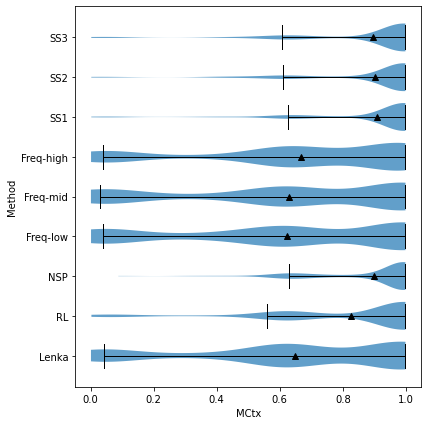

In [ ]:
labels, dataset = zip(*[(f, response_scores[f]) for f in response_files])
m = 0.3
q = 0.1

plt.figure(figsize=(6, 6))
violin = plt.violinplot(dataset, widths=0.7, points=300, vert=False, showextrema=False)
for pc in violin['bodies']:
    pc.set_facecolor('C0')
    pc.set_alpha(0.7)

for i, data in enumerate(dataset):
    # Quantiles
    plt.plot([np.quantile(data, q), np.quantile(data, 1 - q)], [i+1, i+1], c='k', linewidth=1)
    plt.plot([np.quantile(data, q), np.quantile(data, q)], [i+1 - m, i+1 + m], c='k', linewidth=1)
    plt.plot([np.quantile(data, 1 - q), np.quantile(data, 1 - q)], [i+1 - m, i+1 + m], c='k', linewidth=1)

    # means
    plt.plot([np.mean(data)], [i + 1], 'k^')

plt.yticks(np.arange(len(labels)) + 1, labels)
plt.ylabel("Method")
plt.xlabel("MCtx")
plt.savefig('usr_distr.pdf')
plt.show()